In [ ]:
%matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os

os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution

torch.manual_seed(2025)

In [2]:
# ==== 2) load data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [3]:
# ==== 3) preprocess data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


In [4]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

# model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

[Epoch 01] train_loss=0.4461  val_loss=0.4128
[Epoch 02] train_loss=0.3738  val_loss=0.3857
[Epoch 03] train_loss=0.3650  val_loss=0.3714
[Epoch 04] train_loss=0.3558  val_loss=0.3847
[Epoch 05] train_loss=0.3547  val_loss=0.3823
Calibrated Temperature T = 0.939


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/visualization.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


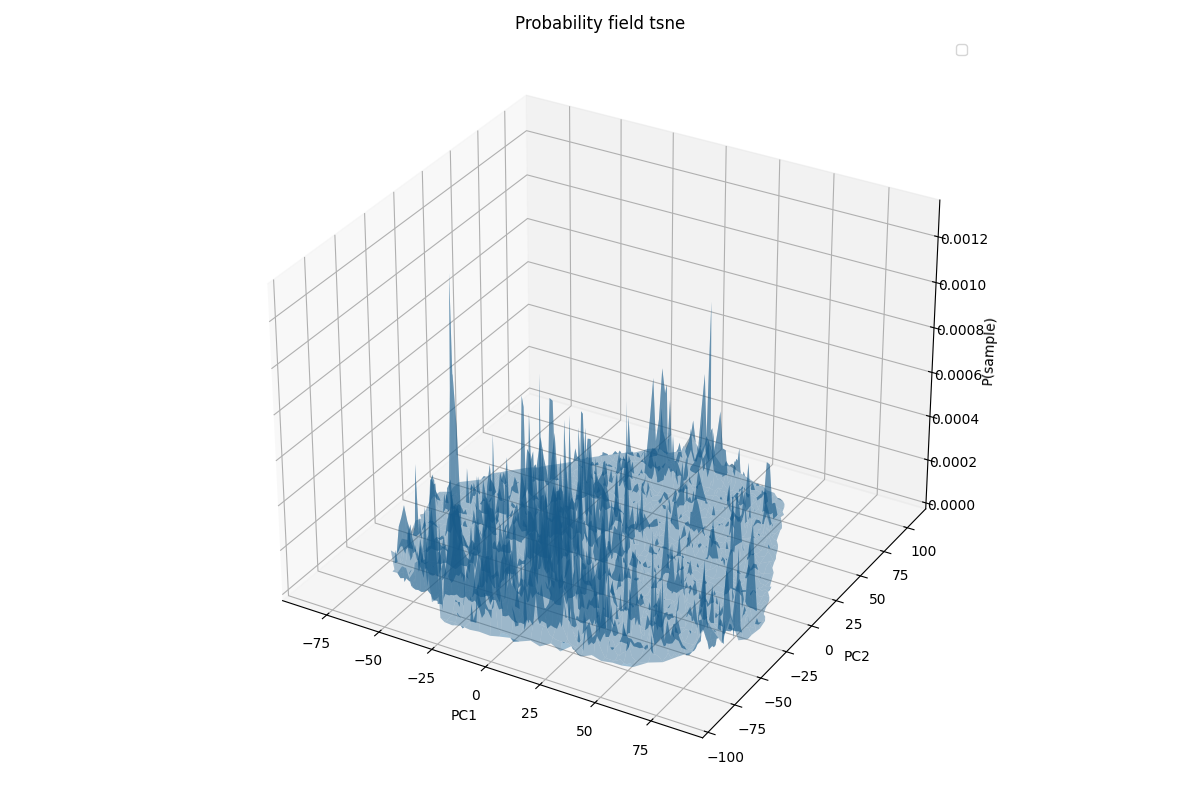

Top-10 features by |corr with Dim1|:
                                  feature  loading_Dim1(corr-style)  loading_Dim2(corr-style)  loading_norm
                  screen size (in inches)                  0.850572                  0.016380      0.850730
  rear camera longest focal length (in x)                 -0.161573                  0.321382      0.359712
                Geekbench multicore score                  0.094069                  0.010277      0.094628
 rear camera main lens resolution (in MP)                 -0.064903                  0.055816      0.085602
battery life (in hours of video playback)                 -0.051155                 -0.093775      0.106820
                        thickness (in mm)                 -0.045465                 -0.745790      0.747174
                                      RAM                 -0.029259                 -0.022561      0.036947
                                    price                  0.021834                 -0.050755      

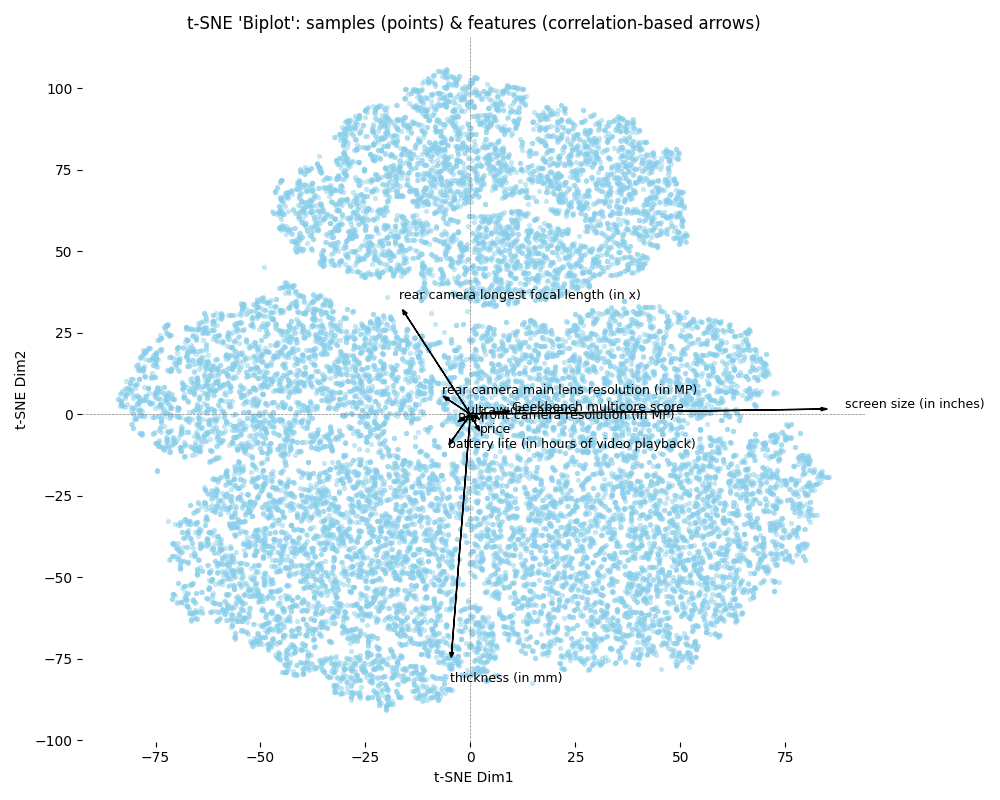

In [5]:
# ==== 5) visualization for training set ====
reduction_model, probs_train, scores_train = visualize_probability_distribution(model, X, T, method='tsne')
feature_names = profiles.columns.tolist()
visualize_tsne_features(reduction_model, X, feature_names)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


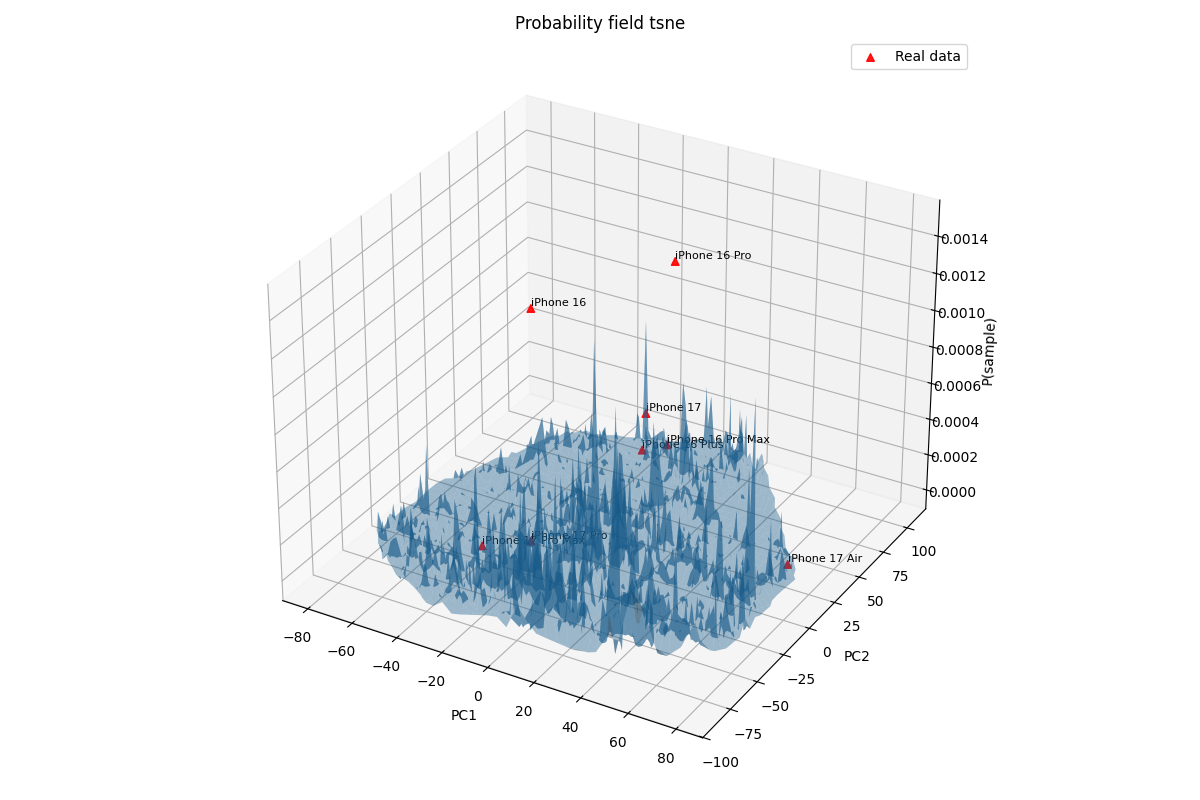

In [6]:
# ==== 6) test on real profiles ====
df_real = pd.read_csv("../data/real_profiles.csv")
X_test = df_real[profiles.columns]
X_test = preprocess_test(X_test)
test_idx = df_real["real model"].tolist()
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([X, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, method='tsne'
)

In [7]:
# print the most likely profile
print(profiles.iloc[scores.argmax()])
print('score: ',scores.max())
print("\n====real profiles====\n")
ranks = scores.argsort()[::-1]
for p, i in zip(range(10000, 10008), test_idx):
    print(f"{i}'s score: {scores[p]:.2f}, rank: {np.where(ranks==p)[0][0]+1}/{len(ranks)}")

battery life (in hours of video playback)        24.0
screen size (in inches)                           6.1
thickness (in mm)                                 7.7
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         48.0
rear camera longest focal length (in x)           3.1
ultrawide camera                             equipped
Geekbench multicore score                      8661.0
RAM                                                 8
price                                           949.0
Name: 12600, dtype: object
score:  3.9737756

====real profiles====

iPhone 16's score: -1.20, rank: 11032/20008
iPhone 16 Plus's score: 1.22, rank: 2829/20008
iPhone 16 Pro's score: -2.55, rank: 14987/20008
iPhone 16 Pro Max's score: 0.55, rank: 5132/20008
iPhone 17's score: -0.54, rank: 9280/20008
iPhone 17 Air's score: -3.21, rank: 17264/20008
iPhone 17 Pro's score: -4.59, rank: 19855/20008
iPhone 17 Pro Max's score: 0.22, rank: 6598/20008
